<a href="https://colab.research.google.com/github/minhyuk0914/Toy_Project/blob/main/Seq2Seq_Logical_Operation/seq2seq_logical_operation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq를 활용한 논리연산($ X_1(AND || OR || XOR) X_2 $)

In [ ]:
import random
import math
import pandas as pd
import numpy as np
import torch

## SET_SEED

In [ ]:
# 시드값 고정
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

## Generate DATASET

In [ ]:
# 데이터셋 생성 함수
def generate_dataset(num_samples=10000):
    data = {
        "x1": [],
        "operator": [],
        "x2": [],
        "input" : [],
        "output": []
    }
    operators = ["AND", "OR", "XOR"]

    for _ in range(num_samples):
        value1 = random.randint(0, 99)
        operator = random.choice(operators)
        value2 = random.randint(0, 99)


        if operator == "AND":
            result = value1 & value2
        elif operator == "OR":
            result = value1 | value2
        elif operator == "XOR":
            result = value1 ^ value2

        data['x1'].append(str(value1))
        data['operator'].append(operator)
        data['x2'].append(str(value2))
        data['input'].append(f"{value1}{operator}{value2}")  # 입력 문자열
        data['output'].append(result)  # 올바른 연산 결과를 타겟으로 추가


    return pd.DataFrame(data)

In [ ]:
df = generate_dataset()
display(df.head())
display(df.shape)

,x1,operator,x2,input,output
0,81,AND,3,81AND3,1
1,94,OR,31,94OR31,95
2,28,AND,94,28AND94,28
3,13,XOR,94,13XOR94,83
4,69,AND,75,69AND75,65


(10000, 5)

## DATASET EDA

* Random을 통한 학습데이터를 생성하였기에, 데이터의 편향 및 분포를 확인하기 위함

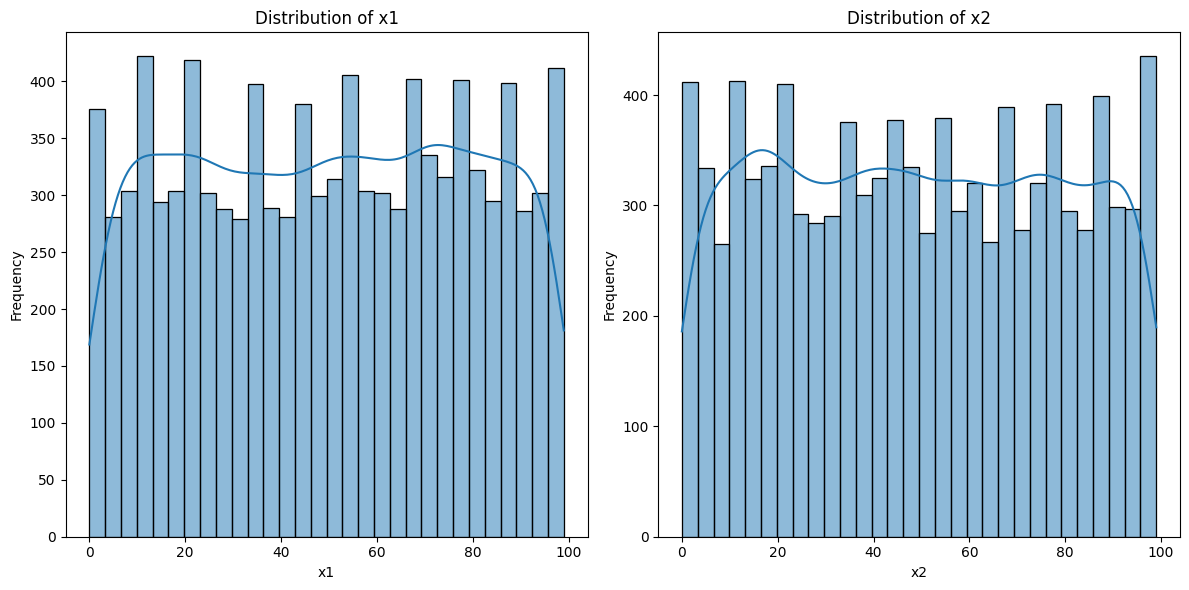

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 서브플롯 생성
plt.figure(figsize=(12, 6))

# x1의 분포 히스토그램
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 서브플롯
sns.histplot(df['x1'].astype(int), bins=30, kde=True)
plt.title('Distribution of x1')
plt.xlabel('x1')
plt.ylabel('Frequency')

# x2의 분포 히스토그램
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 서브플롯
sns.histplot(df['x2'].astype(int), bins=30, kde=True)
plt.title('Distribution of x2')
plt.xlabel('x2')
plt.ylabel('Frequency')

# 레이아웃 조정
plt.tight_layout()
plt.show()



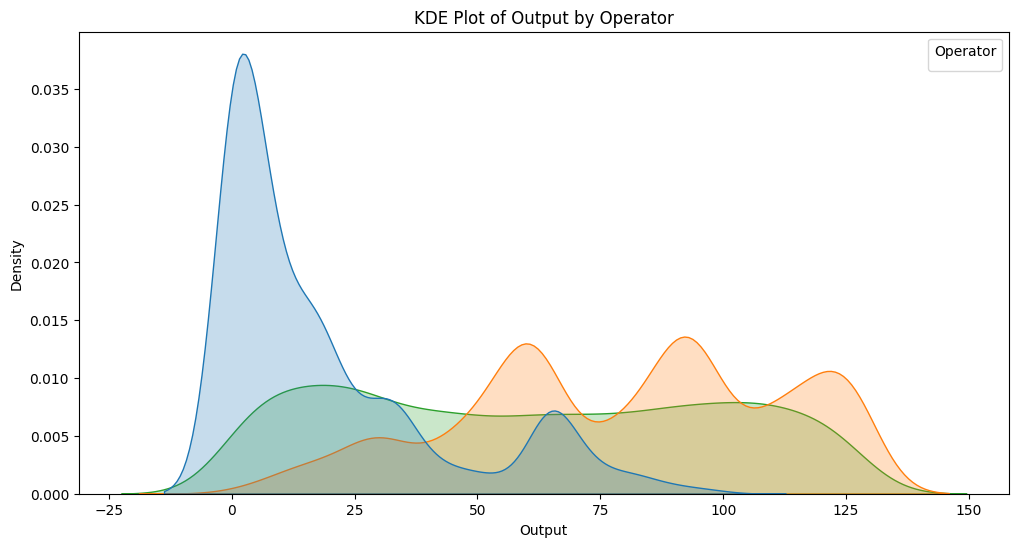

In [ ]:
# output의 분포를 나타내는 커널 밀도 추정(KDE) 플롯

# output 열을 정수형으로 변환
df['output'] = pd.to_numeric(df['output'], errors='coerce')

# KDE 플롯 그리기
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='output', hue='operator', common_norm=False, fill=True)
plt.title('KDE Plot of Output by Operator')
plt.xlabel('Output')
plt.ylabel('Density')
plt.legend(title='Operator')
plt.show()

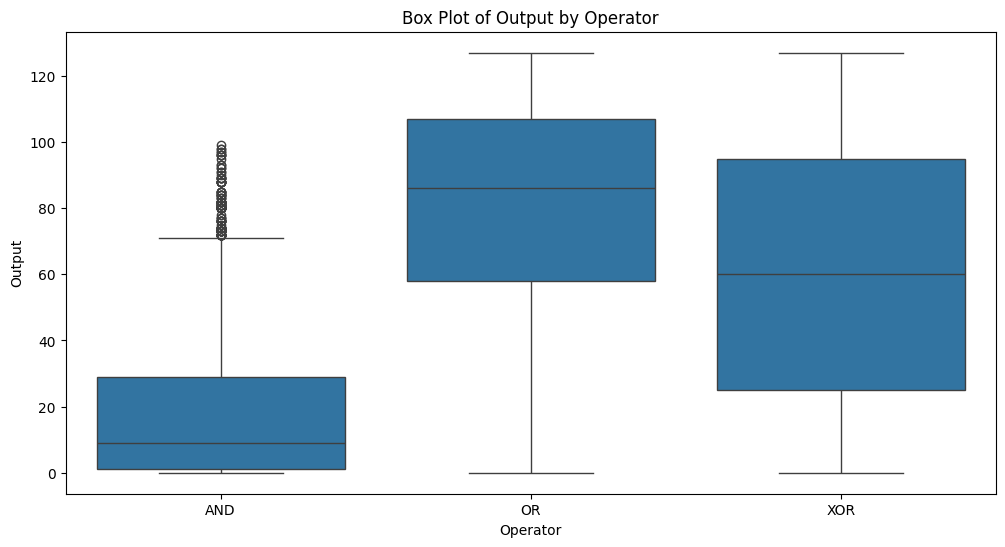

In [ ]:
# output의 박스 플롯

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='operator', y='output')
plt.title('Box Plot of Output by Operator')
plt.xlabel('Operator')
plt.ylabel('Output')
plt.show()

## Make CustomDataset & DataLoader

* 입력 숫자 $ X_1, X_2 $를 인코딩하는 방식이 아닌, 숫자 하나씩을 입력 받아 훈련 데이터에 없는 데이터 또한 예측을 하여 논리연산을 이해시키기 위해 0~9로 매핑
* 두 수의 대한 논리연산 이므로 $ AND, OR, XOR $만 적용 $ NOT $ 은 포함하지 않음
* Seq2Seq 논문에 의거하여, $ <sos>, <eos> $ 토큰을 생성
* $ X_1, X_2 $ 는 최대 두자릿 수로 설정 하였기에, 올바른 예측을 정확도를 위해 $ \# $, Padding token을 추가


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.input_mapping_data = {
            '0': 0,
            '1': 1,
            '2': 2,
            '3': 3,
            '4': 4,
            '5': 5,
            '6': 6,
            '7': 7,
            '8': 8,
            '9': 9,
            'AND': 10,
            'OR' : 11,
            'XOR' : 12,
            '<sos>' : 13,  # Start of Sequence
            '<eos>': 14,  # End of Sequence
            '#': 15        # Padding token

        }
        self.output_mapping_data  = {
            '0': 0,
            '1': 1,
            '2': 2,
            '3': 3,
            '4': 4,
            '5': 5,
            '6': 6,
            '7': 7,
            '8': 8,
            '9': 9,
            '<sos>': 10,  # Start of Sequence
            '<eos>': 11,  # End of Sequence
            '#': 12       # Padding token
        }
        self.max_input_length = 7
        self.max_output_length = 5

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        input_str = self.df.loc[idx, 'input']
        output_str = str(self.df.loc[idx, 'output'])  # 문자열로 변환

        # 입력 데이터 처리: <sos> 추가
        input_data = [self.input_mapping_data['<sos>']]  # <sos> 추가
        i = 0
        while i < len(input_str):
            # 3글자 연산자와 2글자 연산자를 모두 체크
            if input_str[i:i+3] in self.input_mapping_data:  # 'AND', 'XOR' 체크
                input_data.append(self.input_mapping_data[input_str[i:i+3]])
                i += 3  # 연산자 넘어가기
            elif input_str[i:i+2] in self.input_mapping_data:  # 'OR' 체크
                input_data.append(self.input_mapping_data[input_str[i:i+2]])
                i += 2  # 연산자 넘어가기
            else:
                input_data.append(self.input_mapping_data[input_str[i]])
                i += 1  # 숫자 넘어가기

        # <eos> 추가 및 패딩
        input_data.append(self.input_mapping_data['<eos>'])  # <eos> 추가
        input_data = input_data[:self.max_input_length]  # 최대 길이 제한
        input_data += [self.input_mapping_data['#']] * (self.max_input_length - len(input_data))  # 패딩

        # 출력 데이터 처리: <sos>와 <eos> 추가
        output_data = [self.output_mapping_data['<sos>']] + [self.output_mapping_data[x] for x in output_str] + [self.output_mapping_data['<eos>']]
        output_data = output_data[:self.max_output_length]  # 최대 길이 제한
        output_data += [self.output_mapping_data['#']] * (self.max_output_length - len(output_data))  # 패딩

        return torch.tensor(input_data, dtype=torch.long), torch.tensor(output_data, dtype=torch.long)

dataset = CustomDataset(df)

In [ ]:
# Dataset 및 DataLoader 생성
custom_dataset = CustomDataset(df)
BATCH_SIZE = 512
custom_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


dataset_size = len(custom_dataset)
print("datset_size : ", dataset_size)

datset_size :  10000


## Model Define

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)  # Embedding layer
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)  # RNN layer
        self.dropout = nn.Dropout(dropout)  # Dropout layer

    # Encoder는 입력 벡터(source문장) -> 문맥 벡터(context vector)로 반환
    def forward(self, src):
        # src : (batch_size, seq_len)
        embedded = self.embedding(src)  # Convert input tokens to embeddings
        # embedded : (batch_size, seq_len, emb_dim)

        embedded = self.dropout(embedded)  # Apply dropout to the embeddings
        output, (hidden, cell) = self.lstm(embedded)  # Forward pass through RNN

        return hidden, cell

# Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout=0.5):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)  # Embedding layer
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)  # RNN layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)  # Output layer
        self.dropout = nn.Dropout(dropout)  # Dropout layer

    # Decoder는 현재까지 출력된 문장에 대한 정보를 입력으로 받아 타겟 문장으로 반환
    def forward(self, input, hidden, cell):
        input = self.embedding(input)
        input = self.dropout(input)  # Apply dropout to the input
        output, (hidden, cell) = self.lstm(input, (hidden, cell))  # Forward pass through RNN
        prediction = self.fc_out(output)  # Predict next token
        return prediction, hidden, cell

# Seq2Seq LSTM Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg):
        # Encoder를 통과한 문맥 벡터(context vector) 추출
        hidden, cell = self.encoder(src)

        # Decoder의 최종 결과를 담을 객체 생성
        # trg : [batch_size, seq_len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        # 초기 입력 토큰 (첫 번째 입력은 일반적으로 <sos> 토큰)
        input = trg[:, 0].unsqueeze(1)  # (batch_size, 1)

        outputs = torch.zeros(batch_size, trg_len, self.decoder.output_dim).to(self.device)

        for t in range(1, trg_len):  # t=1부터 시작하여 <eos>를 출력할 때까지 반복
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)  # (batch_size, 1, output_dim) -> (batch_size, output_dim)

            # 다음 입력을 현재 예측값으로 설정
            input = output.argmax(2)  # 예측 인덱스를 가져옵니다.

        return outputs  # [batch_size, target_length, num_output_label]

In [ ]:
INPUT_DIM = len(custom_dataset.input_mapping_data)
OUTPUT_DIM = len(custom_dataset.output_mapping_data)
EMB_DIM = 512
HID_DIM = 512
ENC_LAYERS = 4
DEC_LAYERS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS).to(DEVICE)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS).to(DEVICE)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

### Model Summary

In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(16, 512)
    (lstm): LSTM(512, 512, num_layers=4, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(13, 512)
    (lstm): LSTM(512, 512, num_layers=4, batch_first=True, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=13, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## Model - Train

In [ ]:
def train_model(model, dataloader, optimizer, criterion, device, num_epochs, clip_value=None):
    model.train()  # 모델을 학습 모드로 설정

    for epoch in range(num_epochs):
        epoch_loss = 0
        total_samples = 0  # 총 샘플 수

        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs, targets)  # 모델의 예측값 계산

            # 모델 출력 결과와 타겟 사이의 손실 계산
            outputs = outputs.view(-1, outputs.shape[-1])  # [batch_size * seq_len, output_dim]
            targets = targets.view(-1)  # [batch_size * seq_len]
            loss = criterion(outputs, targets)

            loss.backward()  # 역전파

            # 기울기 클리핑 (clip_value가 주어진 경우에만)
            if clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()  # 최적화 수행

            epoch_loss += loss.item()

        # 각 에포크의 평균 손실
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [ ]:
train_model(model, custom_dataloader, optimizer, criterion, DEVICE, num_epochs=100, clip_value = 1)

Epoch 1/100, Loss: 1.9180
Epoch 2/100, Loss: 1.6231
Epoch 3/100, Loss: 1.5526
Epoch 4/100, Loss: 1.4665
Epoch 5/100, Loss: 1.3706
Epoch 6/100, Loss: 1.3087
Epoch 7/100, Loss: 1.2604
Epoch 8/100, Loss: 1.2287
Epoch 9/100, Loss: 1.1916
Epoch 10/100, Loss: 1.1559
Epoch 11/100, Loss: 1.1185
Epoch 12/100, Loss: 1.0773
Epoch 13/100, Loss: 1.0282
Epoch 14/100, Loss: 0.9955
Epoch 15/100, Loss: 0.9643
Epoch 16/100, Loss: 0.9384
Epoch 17/100, Loss: 0.9010
Epoch 18/100, Loss: 0.8708
Epoch 19/100, Loss: 0.8538
Epoch 20/100, Loss: 0.8329
Epoch 21/100, Loss: 0.8182
Epoch 22/100, Loss: 0.8027
Epoch 23/100, Loss: 0.7883
Epoch 24/100, Loss: 0.7667
Epoch 25/100, Loss: 0.7541
Epoch 26/100, Loss: 0.7408
Epoch 27/100, Loss: 0.7264
Epoch 28/100, Loss: 0.7126
Epoch 29/100, Loss: 0.6983
Epoch 30/100, Loss: 0.6859
Epoch 31/100, Loss: 0.6768
Epoch 32/100, Loss: 0.6639
Epoch 33/100, Loss: 0.6614
Epoch 34/100, Loss: 0.6492
Epoch 35/100, Loss: 0.6421
Epoch 36/100, Loss: 0.6382
Epoch 37/100, Loss: 0.6264
Epoch 38/1

## Model - Test



* Debugging용 출력을 추가하여, 모델의 흐름을 파악
    * Output Indices : 전체 인덱스 출력
    * Output String tokens : 최종 문자열 출력
    * Output String : 특수 토큰을 제거한 최종 예측 결과 출력
    

In [ ]:
def test_model(model, input_str, input_mapping, output_mapping, max_input_length, max_output_length):
    model.eval()  # 평가 모드로 전환
    input_data = [input_mapping['<sos>']]  # <sos>로 시작
    i = 0

    # 문자열 입력을 인덱스로 변환
    while i < len(input_str):
        if input_str[i:i+3] in input_mapping:
            input_data.append(input_mapping[input_str[i:i+3]])
            i += 3
        elif input_str[i:i+2] in input_mapping:
            input_data.append(input_mapping[input_str[i:i+2]])
            i += 2
        else:
            input_data.append(input_mapping[input_str[i]])
            i += 1

    input_data.append(input_mapping['<eos>'])  # <eos> 추가
    input_data += [input_mapping['#']] * (max_input_length - len(input_data))  # 패딩 추가
    input_tensor = torch.tensor(input_data, dtype=torch.long).unsqueeze(0).to(model.device)  # 배치 차원 추가

    hidden, cell = model.encoder(input_tensor) # 인코더에 입력 데이터 전달

    # 디코더의 초기 입력과 설정
    output_indices = [output_mapping['<sos>']]
    output_tensor = torch.tensor([output_indices[-1]], dtype=torch.long).unsqueeze(0).to(model.device)  # 첫 <sos> 입력

    for step in range(max_output_length):
        output, hidden, cell = model.decoder(output_tensor, hidden, cell)
        top1 = output.argmax(2).item()  # 예측 결과에서 가장 높은 점수의 인덱스 선택

        output_indices.append(top1)
        output_tensor = torch.tensor([top1], dtype=torch.long).unsqueeze(0).to(model.device)

    # 인덱스를 문자열로 변환
    # 디버깅용 출력
    print("Output Indices:", output_indices)  # 전체 인덱스 출력

    # 인덱스를 문자열로 변환 (특수 토큰 포함)
    output_str = ''.join([k for idx in output_indices for k, v in output_mapping.items() if v == idx])

    print("Output String tokens:", output_str)  # 최종 문자열 출력

    output_str = output_str.replace('<sos>', '').replace('<eos>', '').replace('#', '')  # 특수 토큰 제거
    print("Output String: ", output_str)
    # 예측된 숫자 결과를 반환
    return output_str

## Test Ex1. Ex2. Ex3

사용자로부터 $ X_1, X_2 $를 입력으로 받아, 테스트 및 검증해보기


* test_model로 부터 출력되는 Debugging용 출력 확인
* 실제로 올바르게 적용이 되었는지 논리연산자를 통한 결과 값 비교
* 논리연산은 $ X_1, X_2 $의 순서가 바뀌어도 결과는 동일하지만, 모델이 올바르게 학습을 하였는지 확인하기 위해 순서를 변경한 경우도 출력
* 입력 데이터가 훈련데이터에 존재하는지 확인(논리연산을 올바르게 학습하였는지, 어떤 논리연산은 비교적 적용이 안되었는지, 오류 및 문제를 찾아 개선을 하기 위함)

In [ ]:
# 10 2 입력해보기

operators = ["AND", "OR", "XOR"]

input_x1, input_x2 = map(int, input().split())
print(input_x1, input_x2)

for i in range(3):
    input_str = f"{input_x1}{operators[i]}{input_x2}"
    output_str = test_model(model, input_str, custom_dataset.input_mapping_data, custom_dataset.output_mapping_data, custom_dataset.max_input_length, custom_dataset.max_output_length)

    if operators[i] == 'AND':
        true = input_x1 & input_x2
    elif operators[i] == "OR":
        true = input_x1 | input_x2
    elif operators[i] == "XOR":
        true = input_x1 ^ input_x2

    print(f"Input: {input_str} -> True Output: {true}, Predicted Output: {output_str}")
    print('==' * 20)
display(df[(df['x1'] == str(input_x1)) & (df['x2'] == str(input_x2))])

for i in range(3):
    input_str = f"{input_x2}{operators[i]}{input_x1}"
    output_str = test_model(model, input_str, custom_dataset.input_mapping_data, custom_dataset.output_mapping_data, custom_dataset.max_input_length, custom_dataset.max_output_length)

    if operators[i] == 'AND':
        true = input_x2 & input_x1
    elif operators[i] == "OR":
        true = input_x2 | input_x1
    elif operators[i] == "XOR":
        true = input_x2 ^ input_x1

    print(f"Input: {input_str} -> True Output: {true}, Predicted 1Output: {output_str}")
    print('==' * 20)
display(df[(df['x1'] == str(input_x2)) & (df['x2'] == str(input_x1))])

10 2
10 2
Output Indices: [10, 8, 11, 12, 12, 12]
Output String tokens: <sos>8<eos>###
Output String:  8
Input: 10AND2 -> True Output: 2, Predicted Output: 8
Output Indices: [10, 1, 0, 11, 12, 12]
Output String tokens: <sos>10<eos>##
Output String:  10
Input: 10OR2 -> True Output: 10, Predicted Output: 10
Output Indices: [10, 1, 0, 11, 12, 12]
Output String tokens: <sos>10<eos>##
Output String:  10
Input: 10XOR2 -> True Output: 8, Predicted Output: 10


,x1,operator,x2,input,output
264,10,OR,2,10OR2,10


Output Indices: [10, 2, 11, 12, 12, 12]
Output String tokens: <sos>2<eos>###
Output String:  2
Input: 2AND10 -> True Output: 2, Predicted 1Output: 2
Output Indices: [10, 1, 0, 11, 12, 12]
Output String tokens: <sos>10<eos>##
Output String:  10
Input: 2OR10 -> True Output: 10, Predicted 1Output: 10
Output Indices: [10, 8, 11, 12, 12, 12]
Output String tokens: <sos>8<eos>###
Output String:  8
Input: 2XOR10 -> True Output: 8, Predicted 1Output: 8


,x1,operator,x2,input,output
3307,2,AND,10,2AND10,2


In [ ]:
# 74 27 입력 해보기

operators = ["AND", "OR", "XOR"]

input_x1, input_x2 = map(int, input().split())
print(input_x1, input_x2)

for i in range(3):
    input_str = f"{input_x1}{operators[i]}{input_x2}"
    output_str = test_model(model, input_str, custom_dataset.input_mapping_data, custom_dataset.output_mapping_data, custom_dataset.max_input_length, custom_dataset.max_output_length)

    if operators[i] == 'AND':
        true = input_x1 & input_x2
    elif operators[i] == "OR":
        true = input_x1 | input_x2
    elif operators[i] == "XOR":
        true = input_x1 ^ input_x2

    print(f"Input: {input_str} -> True Output: {true}, Predicted 1Output: {output_str}")
    print('==' * 20)
display(df[(df['x1'] == str(input_x1)) & (df['x2'] == str(input_x2))])

for i in range(3):
    input_str = f"{input_x2}{operators[i]}{input_x1}"
    output_str = test_model(model, input_str, custom_dataset.input_mapping_data, custom_dataset.output_mapping_data, custom_dataset.max_input_length, custom_dataset.max_output_length)

    if operators[i] == 'AND':
        true = input_x2 & input_x1
    elif operators[i] == "OR":
        true = input_x2 | input_x1
    elif operators[i] == "XOR":
        true = input_x2 ^ input_x1

    print(f"Input: {input_str} -> True Output: {true}, Predicted 1Output: {output_str}")
    print('==' * 20)
display(df[(df['x1'] == str(input_x2)) & (df['x2'] == str(input_x1))])

74 27
74 27
Output Indices: [10, 1, 0, 11, 12, 12]
Output String tokens: <sos>10<eos>##
Output String:  10
Input: 74AND27 -> True Output: 10, Predicted 1Output: 10
Output Indices: [10, 9, 1, 11, 12, 12]
Output String tokens: <sos>91<eos>##
Output String:  91
Input: 74OR27 -> True Output: 91, Predicted 1Output: 91
Output Indices: [10, 8, 3, 11, 12, 12]
Output String tokens: <sos>83<eos>##
Output String:  83
Input: 74XOR27 -> True Output: 81, Predicted 1Output: 83


,x1,operator,x2,input,output


Output Indices: [10, 1, 0, 11, 12, 12]
Output String tokens: <sos>10<eos>##
Output String:  10
Input: 27AND74 -> True Output: 10, Predicted 1Output: 10
Output Indices: [10, 9, 1, 11, 12, 12]
Output String tokens: <sos>91<eos>##
Output String:  91
Input: 27OR74 -> True Output: 91, Predicted 1Output: 91
Output Indices: [10, 8, 3, 11, 12, 12]
Output String tokens: <sos>83<eos>##
Output String:  83
Input: 27XOR74 -> True Output: 81, Predicted 1Output: 83


,x1,operator,x2,input,output


In [ ]:
# 20 48 입력해보기

operators = ["AND", "OR", "XOR"]

input_x1, input_x2 = map(int, input().split())
print(input_x1, input_x2)

for i in range(3):
    input_str = f"{input_x1}{operators[i]}{input_x2}"
    output_str = test_model(model, input_str, custom_dataset.input_mapping_data, custom_dataset.output_mapping_data, custom_dataset.max_input_length, custom_dataset.max_output_length)

    if operators[i] == 'AND':
        true = input_x1 & input_x2
    elif operators[i] == "OR":
        true = input_x1 | input_x2
    elif operators[i] == "XOR":
        true = input_x1 ^ input_x2

    print(f"Input: {input_str} -> True Output: {true}, Predicted 1Output: {output_str}")
    print('==' * 20)
display(df[(df['x1'] == str(input_x1)) & (df['x2'] == str(input_x2))])

for i in range(3):
    input_str = f"{input_x2}{operators[i]}{input_x1}"
    output_str = test_model(model, input_str, custom_dataset.input_mapping_data, custom_dataset.output_mapping_data, custom_dataset.max_input_length, custom_dataset.max_output_length)

    if operators[i] == 'AND':
        true = input_x2 & input_x1
    elif operators[i] == "OR":
        true = input_x2 | input_x1
    elif operators[i] == "XOR":
        true = input_x2 ^ input_x1

    print(f"Input: {input_str} -> True Output: {true}, Predicted 1Output: {output_str}")
    print('==' * 20)
display(df[(df['x1'] == str(input_x2)) & (df['x2'] == str(input_x1))])

20 48
20 48
Output Indices: [10, 1, 6, 11, 12, 12]
Output String tokens: <sos>16<eos>##
Output String:  16
Input: 20AND48 -> True Output: 16, Predicted 1Output: 16
Output Indices: [10, 5, 2, 11, 12, 12]
Output String tokens: <sos>52<eos>##
Output String:  52
Input: 20OR48 -> True Output: 52, Predicted 1Output: 52
Output Indices: [10, 3, 6, 11, 12, 12]
Output String tokens: <sos>36<eos>##
Output String:  36
Input: 20XOR48 -> True Output: 36, Predicted 1Output: 36


,x1,operator,x2,input,output


Output Indices: [10, 1, 6, 11, 12, 12]
Output String tokens: <sos>16<eos>##
Output String:  16
Input: 48AND20 -> True Output: 16, Predicted 1Output: 16
Output Indices: [10, 5, 2, 11, 12, 12]
Output String tokens: <sos>52<eos>##
Output String:  52
Input: 48OR20 -> True Output: 52, Predicted 1Output: 52
Output Indices: [10, 3, 6, 11, 12, 12]
Output String tokens: <sos>36<eos>##
Output String:  36
Input: 48XOR20 -> True Output: 36, Predicted 1Output: 36


,x1,operator,x2,input,output
